# Notebook 1: Extract LFP

### Overview
This Jupyter notebook focuses on extracting local field potential (LFP) traces from Spikegadgets `.rec` files, specifically for neuroscience research related to social competition trials. The notebook includes procedures for preprocessing and synchronizing raw electrophysiology data with corresponding video data and computes various metrics, including Z-scored LFPs.

### Inputs & Data Sources
- **Electrophysiology and LFP Parameters**: Constants like `EPHYS_SAMPLING_RATE`, `LFP_SAMPLING_RATE`, `TRIAL_DURATION`, etc., define basic parameters for LFP data processing.
- **Recording Information**: Stream IDs (`ECU_STREAM_ID`, `TRODES_STREAM_ID`), recording extension (`RECORDING_EXTENSION`), and paths to recording directories (`ALL_SESSION_DIR`).
- **DataFrames for Mapping and Timestamps**: `CHANNEL_MAPPING_DF` for channel mapping, and `TONE_TIMESTAMP_DF` for tone timestamps, loaded from external sources.
- **Constants for DataFrame Columns**: Names for various columns in the DataFrame, defined in an all-caps snake case format, such as `EPHYS_INDEX_COL`, `LFP_INDEX_COL`, etc.

### Output & Utility
- **Processed Data**: The notebook outputs processed data, particularly the Z-scored LFP traces, which are critical for further analysis in neuroscience research.
- **Data Files**: Outputs are saved in various formats (`CSV`, `Pickle`) in a specified output directory (`OUTPUT_DIR`).
- **Visualization**: While not explicitly mentioned, the notebook has the potential for data visualization (plots) based on processed LFP data.

### Processing Workflow
1. **LFP Extraction and Preprocessing**: 
    - Iterates through recording sessions to process `.rec` files.
    - Applies a series of preprocessing steps like bandpass filtering, notch filtering, resampling, and Z-scoring on the LFP data.
    - Exception handling for cases where the recording doesn't contain specified stream IDs.

2. **DataFrame Manipulation and Merging**:
    - Filtering `TONE_TIMESTAMP_DF` for trials with obtained LFP.
    - Addition of trial numbers and merging with `CHANNEL_MAPPING_DF`.
    - Dropping unnecessary columns and restructuring for analysis.

3. **LFP Trace Extraction for Each Trial and Brain Region**: 
    - Linking LFP calculations with trials.
    - Creating new rows for each brain region, extracting baseline, trial, and combined LFP traces.
    - Results in a comprehensive DataFrame that combines trial information with corresponding LFP traces.

4. **Data Storage**:
    - Saving processed DataFrame in both `CSV` and `Pickle` formats for easy access and future use.

### Usage Notes
- The notebook is project-specific and tailored for a particular dataset structure, requiring modifications for different data formats.
- Users should ensure file paths and directory names match their project's structure and adjust constants and parameters as needed for their specific analysis requirements.
- The notebook forms a part of a larger research framework, thus necessitating compatibility checks with other components of the project.

### Dependencies
- Python Libraries: `sys`, `os`, `glob`, `numpy`, `pandas`, `spikeinterface`
- External Data: Channel mapping and tone timestamp files, aalone with Spikegadgets `.rec` files.

### Customization and Scalability
- The notebook's modular design allows for easy adaptation to different datasets or extensions to include additional processing steps.
- Functions and processing steps are clearly demarcated, facilitating straightforward updates or enhancements.

### Conclusion
This notebook is a vital tool in the preprocessing and analysis of LFP data from Spikegadgets recordings, integral to neuroscience research focused on social competition trials. It offers a structured approach to handle, process, and store electrophysiological data, ensuring reproducibility and efficiency in research workflows.

In [1]:
import sys
import os
import git

In [2]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [3]:
git_root

'/nancy/user/riwata/projects/reward_comp_ext'

In [4]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [5]:
# Imports of all used packages and libraries
import glob
import numpy as np
import pandas as pd

In [6]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp

In [7]:
from utilities import helper

## Inputs & Data

Explanation of each input and where it comes from.

In [8]:
EPHYS_SAMPLING_RATE = 20000
LFP_SAMPLING_RATE = 1000
LFP_RESAMPLE_RATIO = EPHYS_SAMPLING_RATE / LFP_SAMPLING_RATE
TRIAL_DURATION = 10
FRAME_RATE = 22
ECU_STREAM_ID = "ECU"
TRODES_STREAM_ID = "trodes"
LFP_FREQ_MIN = 0.5
LFP_FREQ_MAX = 300
ELECTRIC_NOISE_FREQ = 60
RECORDING_EXTENTION = "*.rec"

In [9]:
EPHYS_INDEX_COL = "time_stamp_index"
LFP_INDEX_COL = "lfp_index"
EPHYS_TIMESTAMP_COL = "time"
RECORDING_FILE_COL = "recording_file"
RECORDING_DIR_COL = "recording_dir"
BASELINE_LFP_INDEX_RANGE_COL = "baseline_lfp_index_range"
TRIAL_LFP_INDEX_RANGE_COL = "trial_lfp_index_range"
BASELINE_EPHYS_INDEX_RANGE_COL = "baseline_ephys_index_range"
TRIAL_EPHYS_INDEX_RANGE_COL = "trial_ephys_index_range"
BASELINE_VIDEOFRAME_RANGE_COL = "baseline_videoframe_range"
TRIAL_VIDEOFRAME_RANGE_COL = "trial_videoframe_range"
CURRENT_SUBJECT_COL = "current_subject"
ALL_CH_LFP_COL = "all_ch_lfp"
SUBJECT_COL = "Subject"
TRIAL_NUMBER_COL = "trial_number"
SPIKE_INTERFACE_COL = "spike_interface"
EIB_COL = "eib"

In [10]:
LFP_TRACE_COLUMNS = ["session_dir", "recording", "metadata_dir", "metadata_file", "first_dtype_name", "first_item_data", "last_dtype_name", "last_item_data", 'all_subjects', 'current_subject', 'filename']
VIDEO_COLUMNS = ['session_dir', 'recording', 'metadata_dir', 'metadata_file',
      'session_path', 'first_dtype_name', 'first_item_data',
       'all_subjects', 'current_subject', 'filename']

In [11]:
OUTPUT_PREFIX = "rce_pilot_2_comp_standard"

In [12]:
# NOTE: Change based on individual project data location

# Spreadsheet of channel mapping
CHANNEL_MAPPING_DF = pd.read_excel(os.path.join(git_root, "data/rce2_per_subject_channel_mapping.xlsx"))
# Spreadsheet of tone time
SPIKEGADGETS_EXTRACTED_DF = pd.read_pickle("../2024_05_21_extract_timestamps/proc/{}_00_trodes_metadata.pkl".format(OUTPUT_PREFIX))

In [13]:
CHANNEL_MAPPING_DF.head()

,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD
0,1,6.1,NaN,15,14,13,31,21.0,15.0,14.0,13.0,16.0
1,1,6.2,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
2,1,6.3,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
3,1,6.4,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
4,2,1.1,NaN,16,17,18,19,5.0,31.0,30.0,29.0,28.0


In [14]:
# NOTE: Change based on individual project data location
# Where all the recording files are being saved
# ALL_SESSION_DIR = glob.glob("/scratch/back_up/reward_competition_extention/data/standard/2023_06_*/*.rec")
ALL_SESSION_DIR = glob.glob("/scratch/back_up/reward_competition_extention/data/rce_cohort_2/standard/*/*.rec")

In [15]:
ALL_SESSION_DIR

['/scratch/back_up/reward_competition_extention/data/rce_cohort_2/standard/2023_06_14/20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.rec',
 '/scratch/back_up/reward_competition_extention/data/rce_cohort_2/standard/2023_06_13/20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.rec',
 '/scratch/back_up/reward_competition_extention/data/rce_cohort_2/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
 '/scratch/back_up/reward_competition_extention/data/rce_cohort_2/standard/2023_06_12/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.rec',
 '/scratch/back_up/reward_competition_extention/data/rce_cohort_2/standard/2023_06_16/20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.rec']

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

In [16]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [17]:
FULL_LFP_TRACES_PKL = "{}_01_lfp_traces_and_frames.pkl".format(OUTPUT_PREFIX)

# Functions

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [18]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




# Extracting the LFP

In [19]:
SPIKEGADGETS_EXTRACTED_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,last_timestamp,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps
0,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [..."
1,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [..."
2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [..."
3,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [..."
4,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,76318450,"[1384, 2444, 2769, 4155, 5541, 6708, 6927, 831...","[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [..."


In [20]:
recording_name_to_all_ch_lfp = {}
# Going through all the recording sessions 
for session_dir in ALL_SESSION_DIR:
    # Going through all the recordings in each session
    for recording_path in glob.glob(os.path.join(session_dir, RECORDING_EXTENTION)):
        try:
            recording_basename = os.path.splitext(os.path.basename(recording_path))[0]
            # checking to see if the recording has an ECU component
            # if it doesn't, then the next one be extracted
            current_recording = se.read_spikegadgets(recording_path, stream_id=ECU_STREAM_ID)
            current_recording = se.read_spikegadgets(recording_path, stream_id=TRODES_STREAM_ID)
            print(recording_basename)

            # Preprocessing the LFP
            current_recording = sp.notch_filter(current_recording, freq=ELECTRIC_NOISE_FREQ)
            current_recording = sp.bandpass_filter(current_recording, freq_min=LFP_FREQ_MIN, freq_max=LFP_FREQ_MAX)
            current_recording = sp.resample(current_recording, resample_rate=LFP_SAMPLING_RATE)            
            recording_name_to_all_ch_lfp[recording_basename] = current_recording
        except Exception as error:
            # handle the exception
            print("An exception occurred:", error) # An exception occurred: division by zero
        
    




An exception occurred: stream_id trodes is not in ['ECU']
20230614_114041_standard_comp_to_training_D3_subj_1-2_t2b2L_box2_merged
20230614_114041_standard_comp_to_training_D3_subj_1-1_t1b3L_box1_merged
An exception occurred: stream_id trodes is not in ['ECU']
20230613_105657_standard_comp_to_training_D2_subj_1-4_t4b3L_box2_merged
20230613_105657_standard_comp_to_training_D2_subj_1-1_t1b2L_box1_merged
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
An exception occurred: stream_id trodes is not in ['ECU']
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged
An exception occurred: stream_id trodes is not in ['ECU']
20230612_112630_standard_comp_to_training_D1_subj_1-1_t1b3L_box2_merged
An exception occurred: stream_id trodes is not in ['ECU']
20230616_111904_standard_comp_to_training_D4_subj_1-4_t4b3L_box1_merged
20230616_111904_standard_comp_to_training_D4_subj_1-2_t2b2L_bo

- Combining LFP traces with metadata

In [21]:
# Filtering for rows that are the metadata for the raw recordings
# lfp_trace_condition = (SPIKEGADGETS_EXTRACTED_DF["recording"].isin(recording_name_to_all_ch_lfp) & (SPIKEGADGETS_EXTRACTED_DF["metadata_dir"] == "raw") & (SPIKEGADGETS_EXTRACTED_DF["metadata_file"] == "timestamps"))
lfp_trace_condition = (SPIKEGADGETS_EXTRACTED_DF["recording"].isin(recording_name_to_all_ch_lfp))

SPIKEGADGETS_LFP_DF = SPIKEGADGETS_EXTRACTED_DF[lfp_trace_condition].copy().reset_index(drop=True)
# Removing the columns that are not needed
# SPIKEGADGETS_LFP_DF = SPIKEGADGETS_LFP_DF[LFP_TRACE_COLUMNS]

In [22]:
# Adding the LFP traces to the metadata dataframe
SPIKEGADGETS_LFP_DF["all_ch_lfp"] = SPIKEGADGETS_LFP_DF["recording"].map(recording_name_to_all_ch_lfp)

## Get the timestamp of the LFP

In [23]:
SPIKEGADGETS_LFP_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,last_timestamp,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps,all_ch_lfp
0,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...
1,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...
2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...
3,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...
4,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,76318450,"[1384, 2444, 2769, 4155, 5541, 6708, 6927, 831...","[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...


In [24]:
# Getting the timestamps for the LFP traces by resampling the raw timestamps
SPIKEGADGETS_LFP_DF["LFP_timestamps"] = SPIKEGADGETS_LFP_DF.apply(lambda row: np.arange(0, row["all_ch_lfp"].get_total_samples()*LFP_RESAMPLE_RATIO, LFP_RESAMPLE_RATIO, dtype=int), axis=1)

# SPIKEGADGETS_LFP_DF["LFP_timestamps"] = SPIKEGADGETS_LFP_DF.apply(lambda row: np.arange(row["first_timestamp"]-row["first_timestamp"], row["last_timestamp"]-row["first_timestamp"], LFP_RESAMPLE_RATIO, dtype=np.int32), axis=1)
                                                                  
                                                                  


In [25]:
SPIKEGADGETS_LFP_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,last_timestamp,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps,all_ch_lfp,LFP_timestamps
0,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
1,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
3,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
4,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,76318450,"[1384, 2444, 2769, 4155, 5541, 6708, 6927, 831...","[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."


In [26]:
SPIKEGADGETS_LFP_DF["all_ch_lfp"].iloc[0]

ResampleRecording: 32 channels - 1.0kHz - 1 segments - 3,414,668 samples 
                   3,414.67s (56.91 minutes) - int16 dtype - 208.41 MiB

In [27]:
SPIKEGADGETS_LFP_DF["LFP_timestamps"].iloc[0][0]


0

In [28]:
SPIKEGADGETS_LFP_DF["LFP_timestamps"].iloc[0].shape

(3414668,)

## Adding the channel mapping

In [29]:
CHANNEL_MAPPING_DF = CHANNEL_MAPPING_DF.drop(columns=[col for col in CHANNEL_MAPPING_DF.columns if "eib" in col], errors="ignore")

In [30]:
for col in CHANNEL_MAPPING_DF.columns:
    if "spike_interface" in col:
        CHANNEL_MAPPING_DF[col] = CHANNEL_MAPPING_DF[col].fillna(0)
        CHANNEL_MAPPING_DF[col] = CHANNEL_MAPPING_DF[col].astype(int).astype(str)

In [31]:
CHANNEL_MAPPING_DF

,Cohort,Subject,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD
0,1,6.1,21,15,14,13,16
1,1,6.2,0,0,0,0,0
2,1,6.3,0,0,0,0,0
3,1,6.4,0,0,0,0,0
4,2,1.1,5,31,30,29,28
5,2,1.2,10,31,30,29,28
6,2,1.3,9,31,30,29,28
7,2,1.4,15,31,30,29,28


- Adding all the brain region to ch information

In [32]:
CHANNEL_MAPPING_DF[SUBJECT_COL] = CHANNEL_MAPPING_DF[SUBJECT_COL].astype(str)

- Merging the recording and the channel dataframes

In [33]:
SPIKEGADGETS_LFP_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,last_timestamp,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps,all_ch_lfp,LFP_timestamps
0,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
1,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
3,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."
4,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,76318450,"[1384, 2444, 2769, 4155, 5541, 6708, 6927, 831...","[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2..."


In [34]:
SPIKEGADGETS_LFP_DF = pd.merge(SPIKEGADGETS_LFP_DF, CHANNEL_MAPPING_DF, left_on=CURRENT_SUBJECT_COL, right_on=SUBJECT_COL, how="left")



In [35]:
SPIKEGADGETS_LFP_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,...,box_2_port_entry_timestamps,all_ch_lfp,LFP_timestamps,Cohort,Subject,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD
0,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,"[1.3, 1.4]",8798886,...,"[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",2,1.3,9,31,30,29,28
1,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,"[1.3, 1.4]",8798886,...,"[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",2,1.3,9,31,30,29,28
2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,"[1.3, 1.4]",8798886,...,"[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",2,1.4,15,31,30,29,28
3,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,"[1.3, 1.4]",8798886,...,"[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",2,1.4,15,31,30,29,28
4,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,...,"[[33037711, 33038706], [33264908, 33270313], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",2,1.1,5,31,30,29,28


# Getting the channel specific LFP traces

- Linking up all LFP calculations with all the trials

- Extracting the traces for each brain region

In [36]:
SPIKEGADGETS_LFP_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,...,box_2_port_entry_timestamps,all_ch_lfp,LFP_timestamps,Cohort,Subject,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD
0,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,"[1.3, 1.4]",8798886,...,"[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",2,1.3,9,31,30,29,28
1,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,"[1.3, 1.4]",8798886,...,"[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",2,1.3,9,31,30,29,28
2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,"[1.3, 1.4]",8798886,...,"[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",2,1.4,15,31,30,29,28
3,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,"[1.3, 1.4]",8798886,...,"[[33082200, 33090003], [33565003, 33567000], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",2,1.4,15,31,30,29,28
4,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,...,"[[33037711, 33038706], [33264908, 33270313], [...",ResampleRecording: 32 channels - 1.0kHz - 1 se...,"[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...",2,1.1,5,31,30,29,28


In [37]:
SPIKEGADGETS_LFP_DF["all_channels"] = SPIKEGADGETS_LFP_DF["all_ch_lfp"].apply(lambda x: x.get_channel_ids())

In [38]:
SPIKEGADGETS_LFP_DF["region_channels"] = SPIKEGADGETS_LFP_DF[["spike_interface_mPFC", "spike_interface_vHPC", "spike_interface_BLA", "spike_interface_LH", "spike_interface_MD"]].to_dict('records')

In [39]:
SPIKEGADGETS_LFP_DF["region_channels"] = SPIKEGADGETS_LFP_DF["region_channels"].apply(lambda x: sorted(x.items(), key=lambda item: int(item[1])))


In [40]:
SPIKEGADGETS_LFP_DF["region_channels"].iloc[0]

[('spike_interface_mPFC', '9'),
 ('spike_interface_MD', '28'),
 ('spike_interface_LH', '29'),
 ('spike_interface_BLA', '30'),
 ('spike_interface_vHPC', '31')]

In [41]:
SPIKEGADGETS_LFP_DF["all_channels"].iloc[0]

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U64')

In [42]:
example_spike_interface = SPIKEGADGETS_LFP_DF["all_ch_lfp"].iloc[0]


In [43]:
start_frame = 10*60*1000
stop_frame = 15*60*1000

In [44]:
start_frame

600000

In [45]:
stop_frame

900000

In [46]:
example_spike_interface.get_num_samples()

3414668

In [47]:
SPIKEGADGETS_LFP_DF["all_region_lfp_trace"] = SPIKEGADGETS_LFP_DF.apply(lambda row: row[ALL_CH_LFP_COL].get_traces(start_frame=start_frame, end_frame=stop_frame).T, axis=1)

In [48]:
SPIKEGADGETS_LFP_DF["per_region_lfp_trace"] = SPIKEGADGETS_LFP_DF.apply(lambda row: dict(zip([t for t in row["all_channels"]], row["all_region_lfp_trace"])), axis=1)

In [49]:
SPIKEGADGETS_LFP_DF = SPIKEGADGETS_LFP_DF.drop_duplicates(subset=["recording"])

In [50]:
SPIKEGADGETS_LFP_DF["per_region_lfp_trace"]

0     {'0': [-3, -5, -54, -146, -132, -37, 36, 78, 1...
2     {'0': [44, 43, 51, 61, 44, 17, 25, 55, 64, 60,...
4     {'0': [536, 476, 371, 142, 245, 455, 465, 576,...
6     {'0': [-755, -886, -974, -928, -787, -727, -79...
8     {'0': [-94, 232, 436, 273, 107, 155, 210, 78, ...
10    {'0': [38, 19, 72, 154, 188, 250, 291, 216, 10...
12    {'0': [-652, -750, -706, -583, -385, -197, -15...
15    {'0': [702, 613, 650, 757, 758, 680, 610, 476,...
18    {'0': [-172, 50, 215, 298, 458, 757, 868, 616,...
20    {'0': [-18, 36, -9, 14, 98, 128, 168, 170, 121...
Name: per_region_lfp_trace, dtype: object

In [51]:
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines

In [52]:
channel_groups = 4

In [53]:
duration = 500

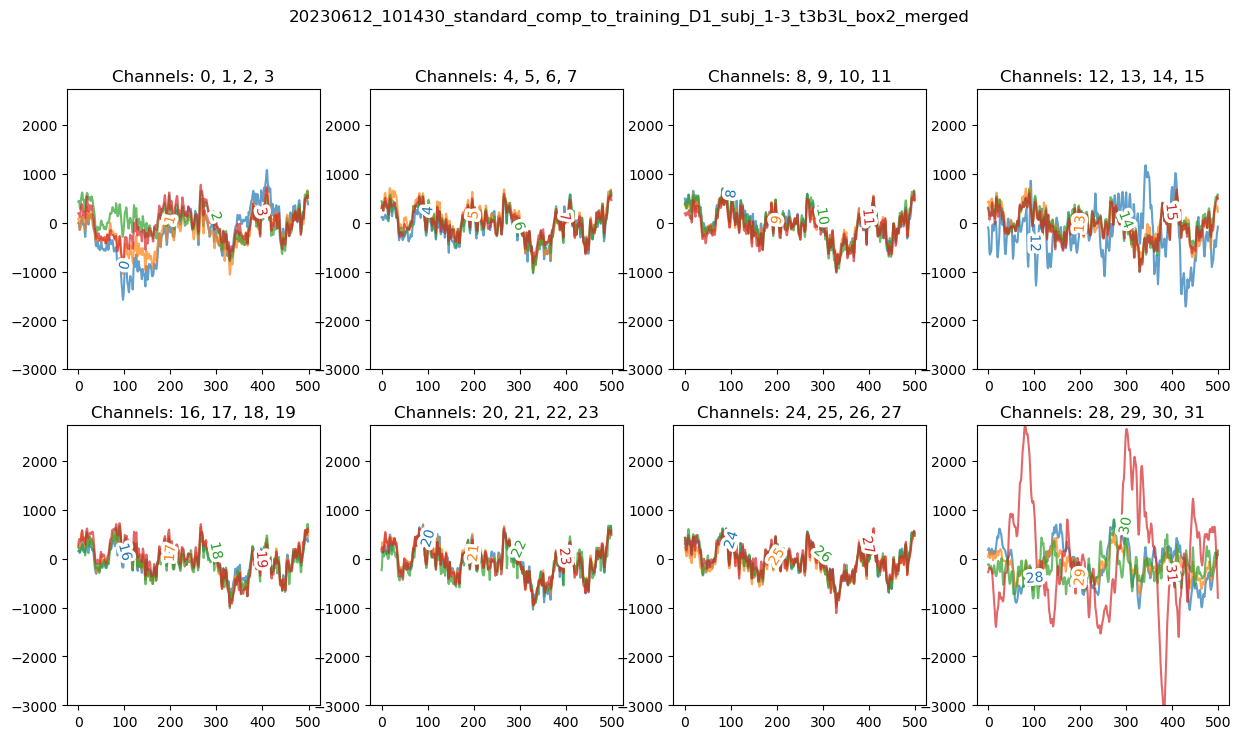

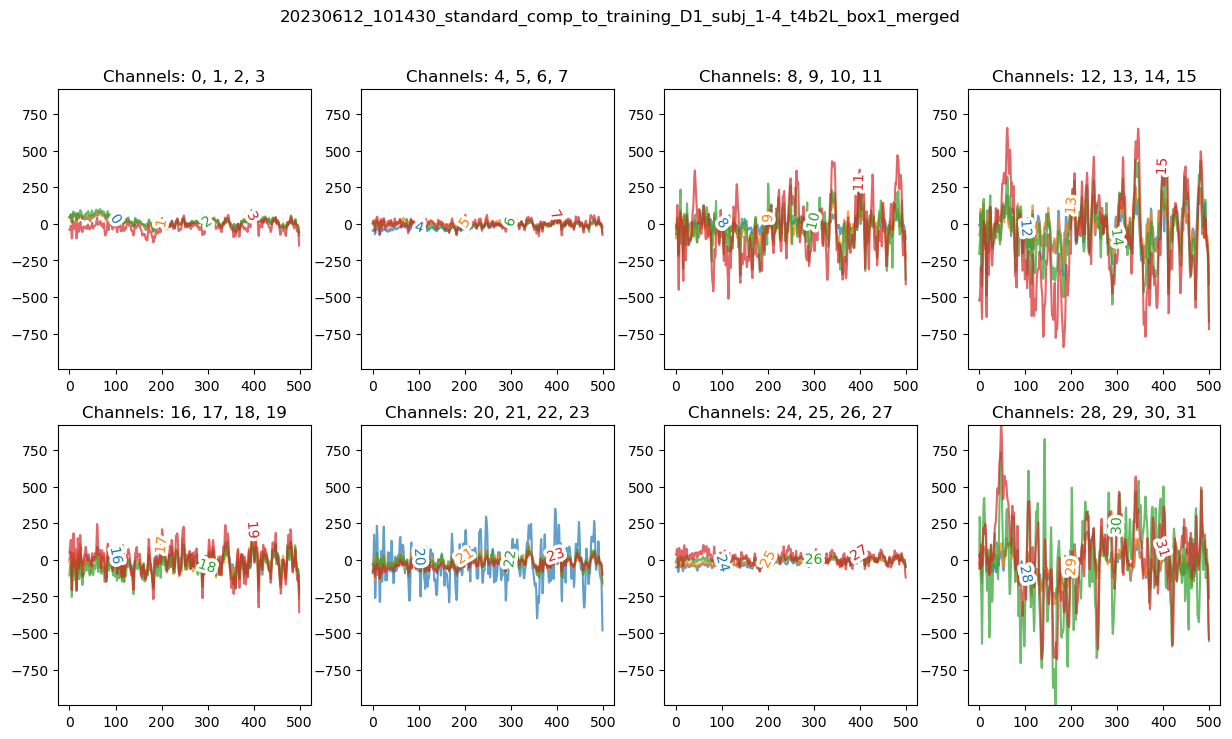

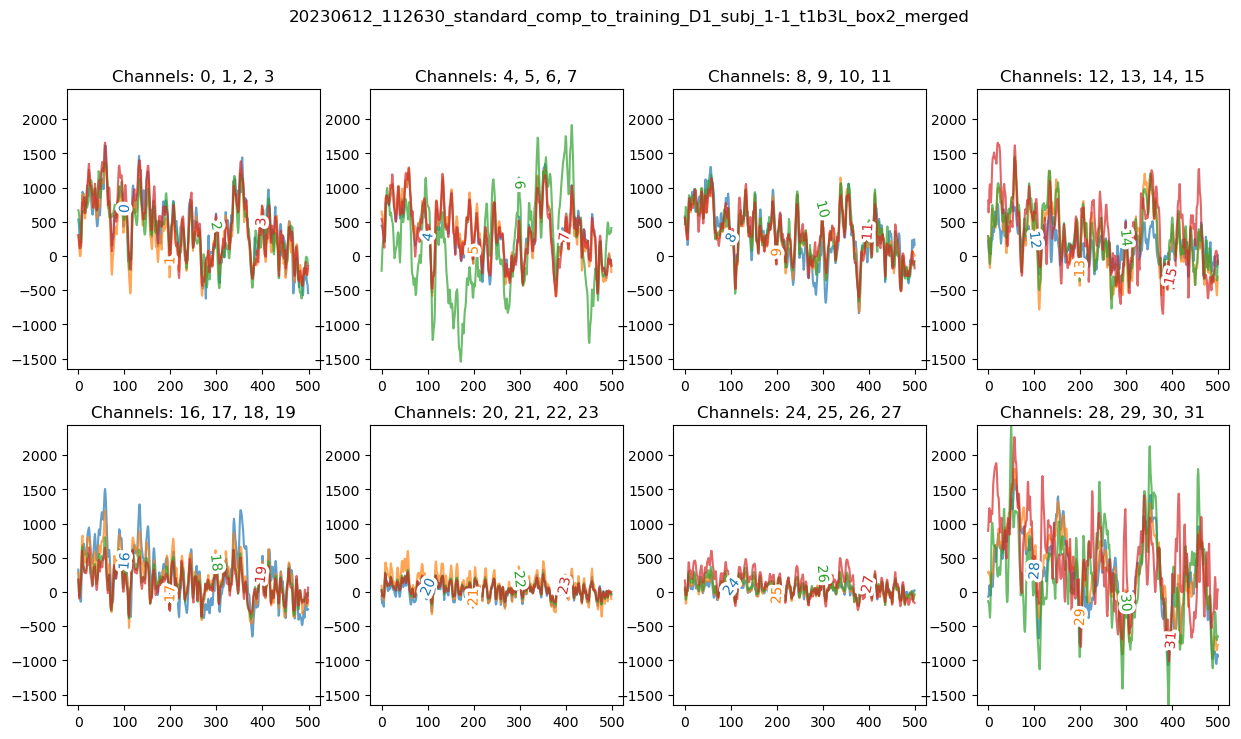

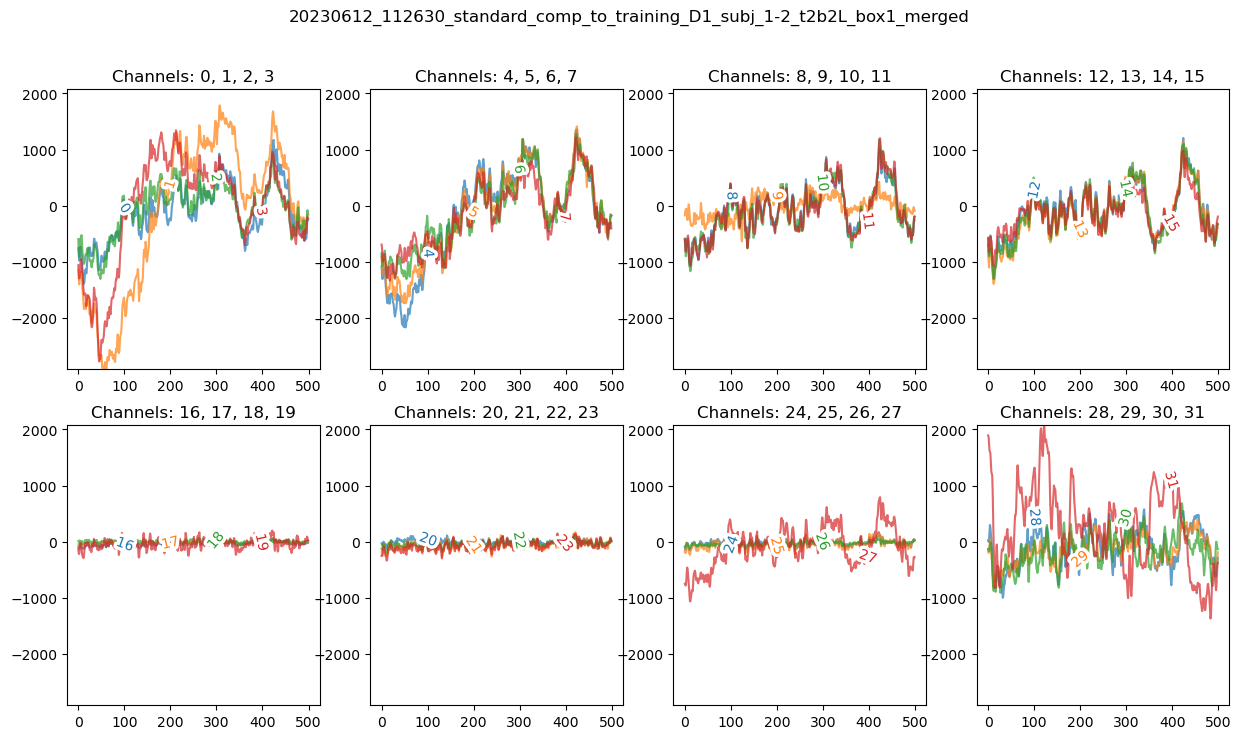

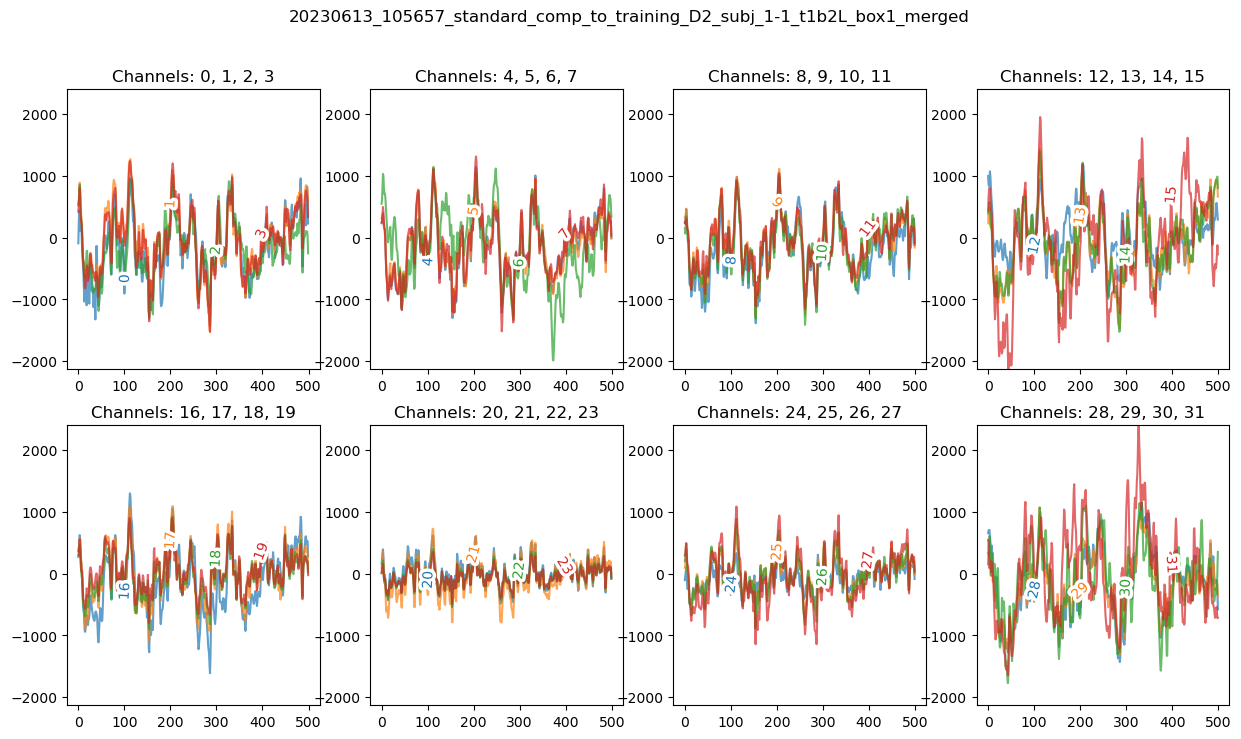

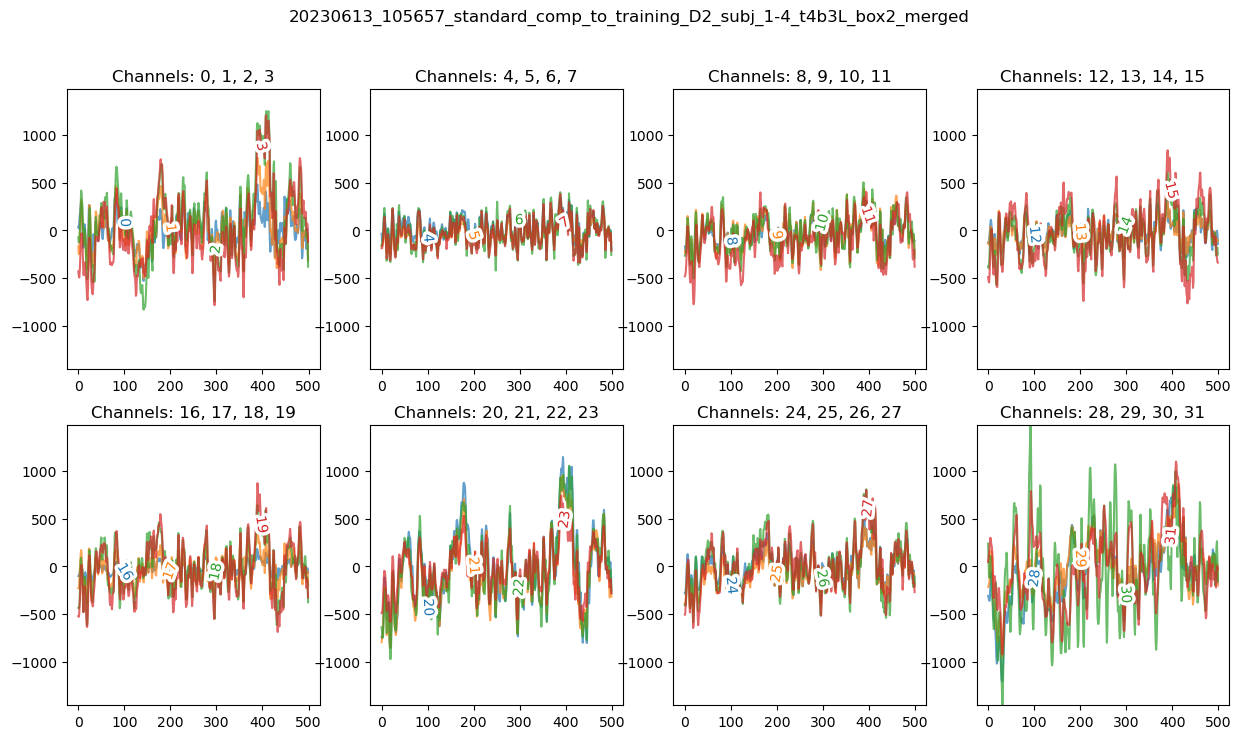

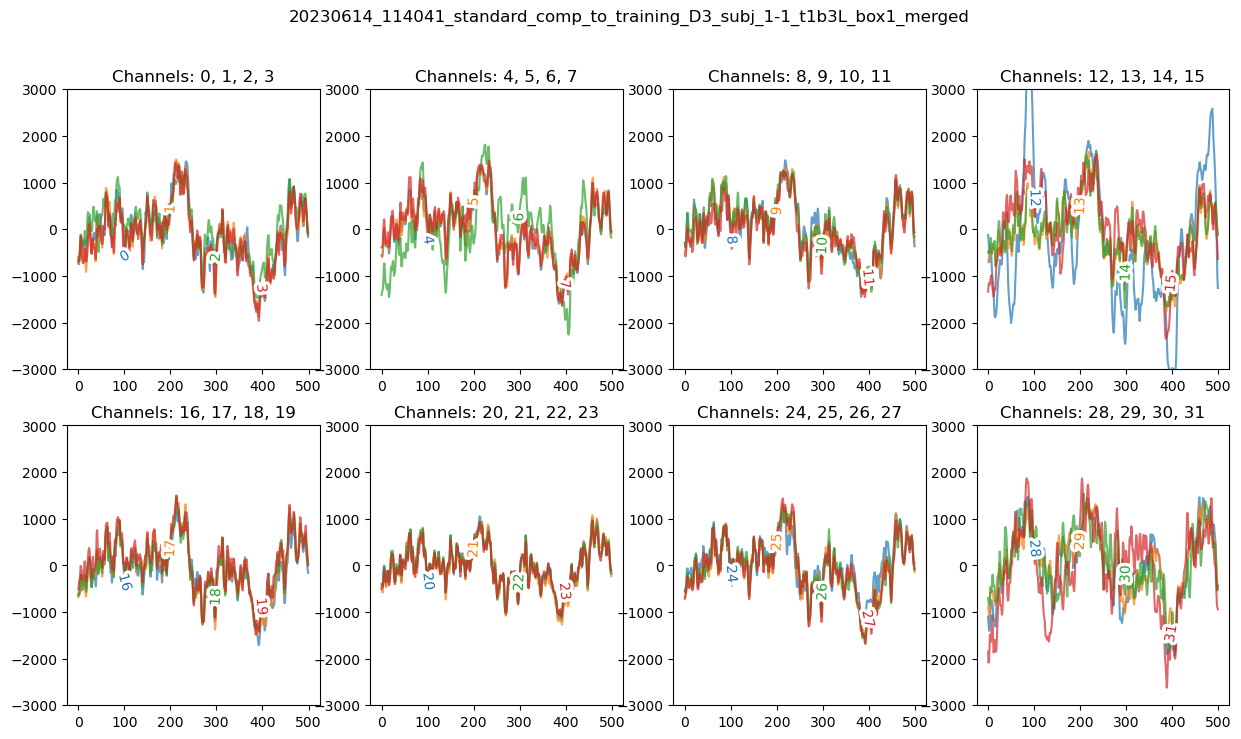

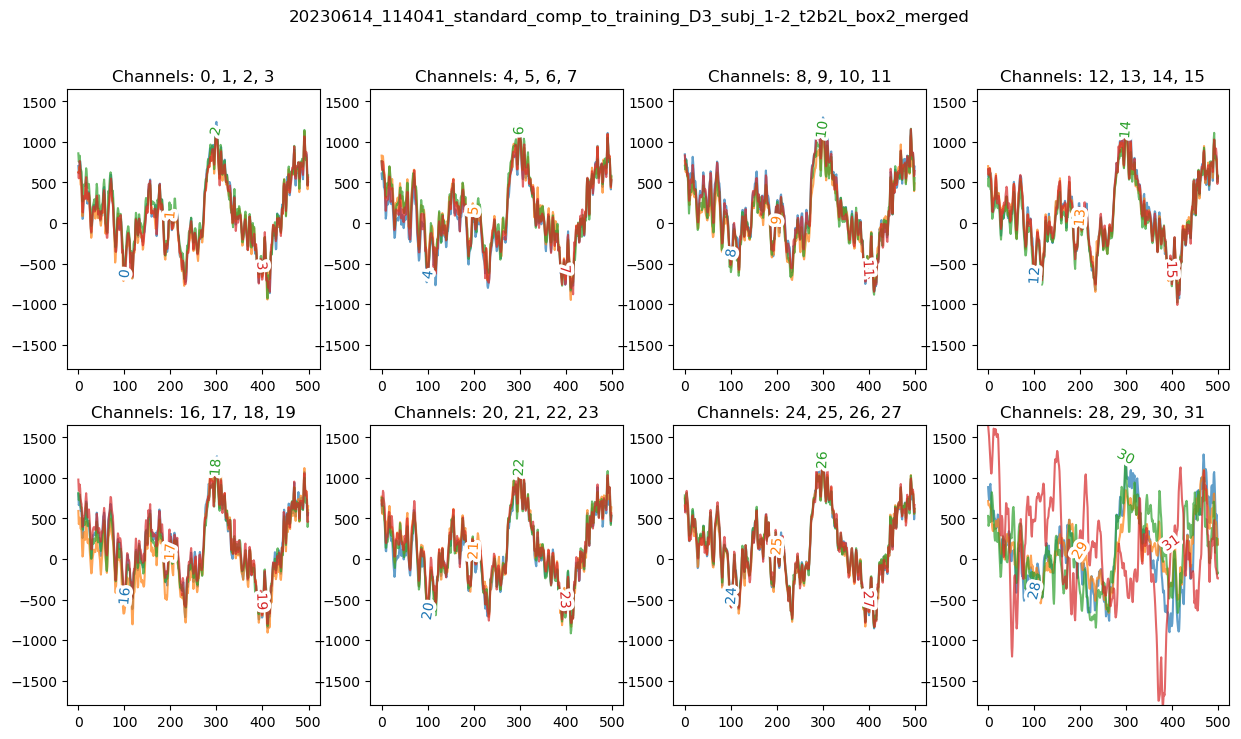

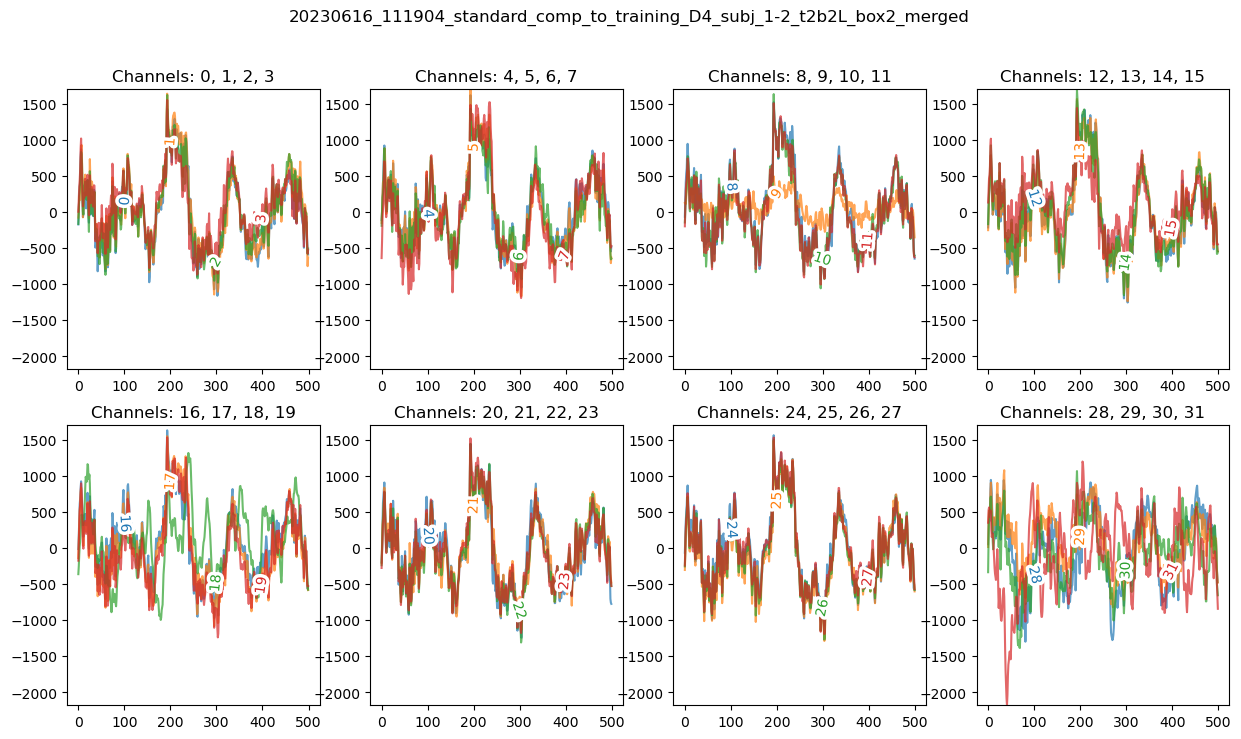

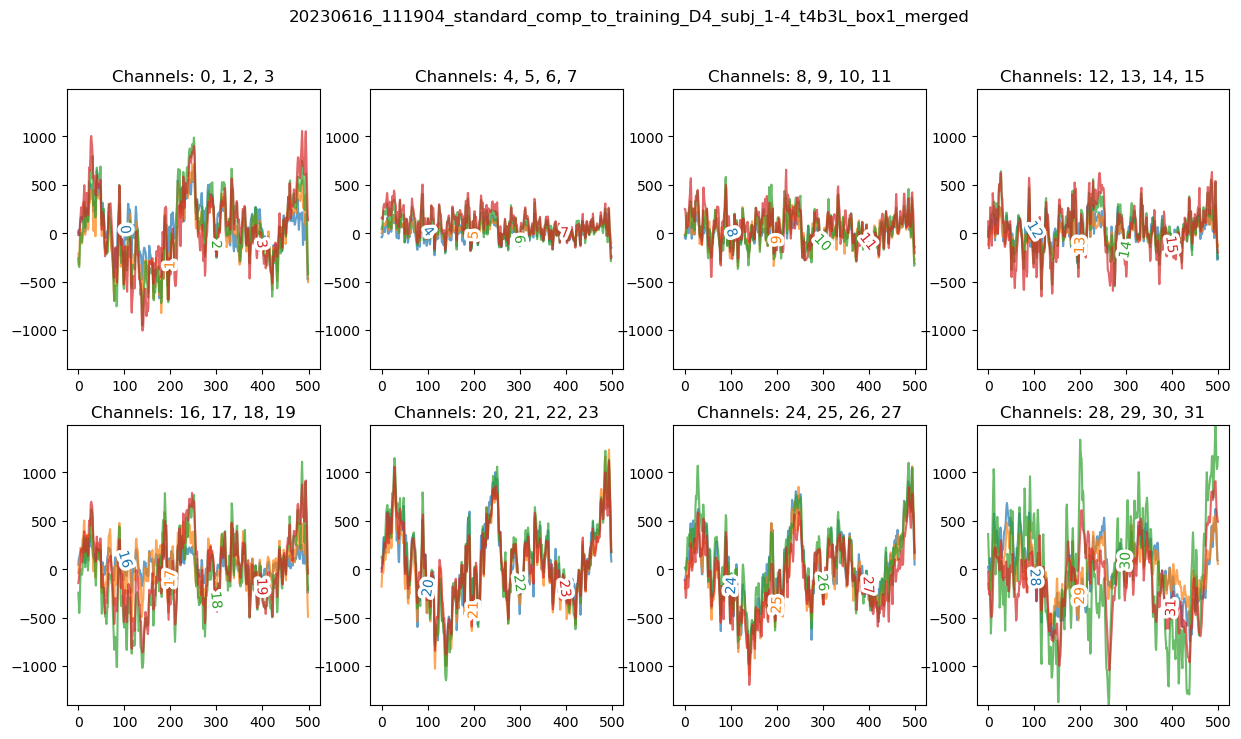

In [54]:
# Assuming SPIKEGADGETS_LFP_DF is your DataFrame
channel_groups = 4  # Assuming you have 8 channels per group
plot_count = 0  # Counter to keep track of how many plots are in the current subplot

for index, row in SPIKEGADGETS_LFP_DF.iterrows():
    fig, axs = plt.subplots(2, 4, figsize=(15, 8))  # Create the figure and 8 subplots (2x4)
    fig.suptitle(row["recording"])  # Set the title for the entire figure
    all_traces = np.array(list(row["per_region_lfp_trace"].values()))[:, :duration]
    max_value = np.nanmax(all_traces)
    min_value = np.nanmin(all_traces)

    if max_value >= 3000:
        max_value = 3000
    if min_value <= -3000:
        min_value = -3000

    for num in range(len(row["per_region_lfp_trace"]) // channel_groups):
        all_channels = []
        ax = axs[num // 4, num % 4]  # Select the appropriate subplot

        for channel_displacement in range(channel_groups):
            current_ch = str(int(num * channel_groups + channel_displacement))
            trace = row["per_region_lfp_trace"][current_ch]
            ax.plot(trace[:duration], label=current_ch, alpha=0.7)  # Plot the trace
            all_channels.append(current_ch)

        labelLines(ax.get_lines(), zorder=2.5)
        ax.set_ylim(min_value, max_value)
        ax.set_title("Channels: " + ", ".join(all_channels))  # Set a title for each subplot

    plt.savefig("./proc/{}.png".format(row["recording"]))
    plt.show()